#### FA23 DAAN570 - Deep Learning
#### Project: UAV Control using CNN and ViT Gesture Recognition
#### Model: Model 12 (EfficientNetB0)
##### Students: Aureo Zanon and Johnny Zielinski (Team 15)
##### Date: December 6th, 2023

In [2]:
# Loading the required libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import EfficientNetB0
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [3]:
# Setting the base_path to the images 
base_path = '//Users//aureozanon//Documents//DAAN570//Project//HG_Data//'  # Feel free to use your actual path to the 'images' directory (we also changed it to connect to the AWS S3 bucket after some IAM config)

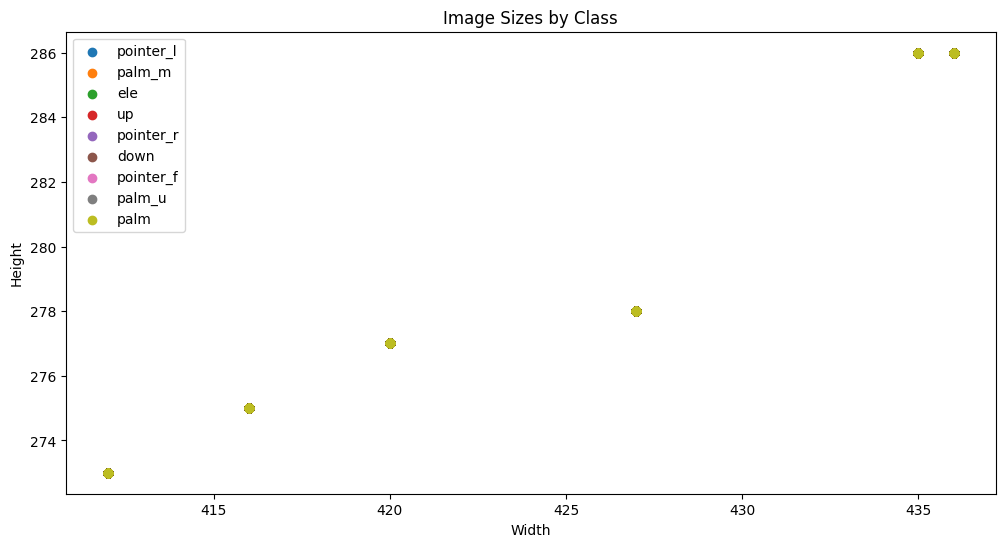

In [4]:
# Visualizing the different images sizes

# Initialize dictionaries to store image sizes
image_sizes = {}
image_formats = {}

# Iterate over each class directory
for class_dir in os.listdir(base_path):
    class_dir_path = os.path.join(base_path, class_dir)
    if os.path.isdir(class_dir_path):
        image_sizes[class_dir] = []
        image_formats[class_dir] = []

        # Iterate over each image in the class directory
        for img_file in os.listdir(class_dir_path):
            img_path = os.path.join(class_dir_path, img_file)
            try:
                with Image.open(img_path) as img:
                    # Store image sizes and formats
                    image_sizes[class_dir].append(img.size)
                    image_formats[class_dir].append(img.format)
            except IOError:
                pass  # Ignore files that are not images

# Plotting image sizes
plt.figure(figsize=(12, 6))
for class_dir, sizes in image_sizes.items():
    widths, heights = zip(*sizes)
    plt.scatter(widths, heights, label=class_dir)
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Image Sizes by Class')
plt.legend()
plt.show()


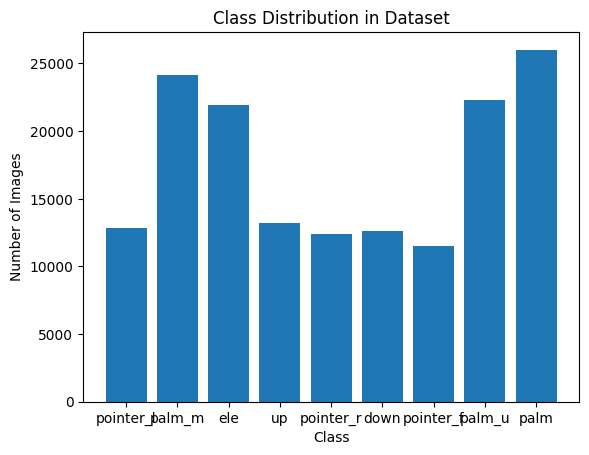

In [14]:
# Checking for imbalanced data

class_counts = {}

for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = len(os.listdir(class_path))

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Dataset')
plt.show()


In [8]:
# Setting the target size for all images to a common size of 224x224 pixels.
target_size = (224, 224)

In [75]:
# Creating an instance of the ImageDataGenerator class with specified augmentation parameters:
datagen = ImageDataGenerator(
    rescale=1./255,           # Rescales the pixel values in images to the range [0, 1].
    rotation_range=40,        # Randomly rotates images within this degree range.
    width_shift_range=0.2,    # Randomly shifts images horizontally by a fraction of the total width.
    height_shift_range=0.2,   # Randomly shifts images vertically by a fraction of the total height.
    shear_range=0.2,          # Randomly applies shearing transformations.
    zoom_range=0.2,           # Randomly zooms inside the images.
    horizontal_flip=True,     # Randomly flips half of the images horizontally.
    validation_split=0.1,     # Decided to use 10% of the data as validation (test) set due to the large size of our dataset
    fill_mode='nearest'       # Sets the strategy used for filling in newly created pixels, which can appear after a rotation or width/height shift.
)

# Using a subset of the original dataset with 9 classes that were previously selected. Excluded classes: palm_o, pointer, and pointer_b

In [ ]:
# Creating the training and validation generators
train_generator = datagen.flow_from_directory(
    base_path,                      # Specify the path to the directory with training images
    target_size=target_size,        # Define the target size of the images (e.g., (224, 224))
    batch_size=32,                  # Set the size of the batches of data (number of images per batch)
    class_mode='categorical',       # Set the class mode to 'categorical' for multi-class classification
    subset='training',               # Specify that this is for the training subset
    seed = 74,
)

validation_generator = datagen.flow_from_directory(
    base_path,                      # Specify the path to the directory with validation images
    target_size=target_size,        # Define the target size of the images (e.g., (224, 224))
    batch_size=32,                  # Set the size of the batches of data (number of images per batch)
    class_mode='categorical',       # Set the class mode to 'categorical' for multi-class classification
    subset='validation',             # Specify that this is for the validation subset
    seed=74,
)


Found 141305 images belonging to 9 classes.
Found 15697 images belonging to 9 classes.


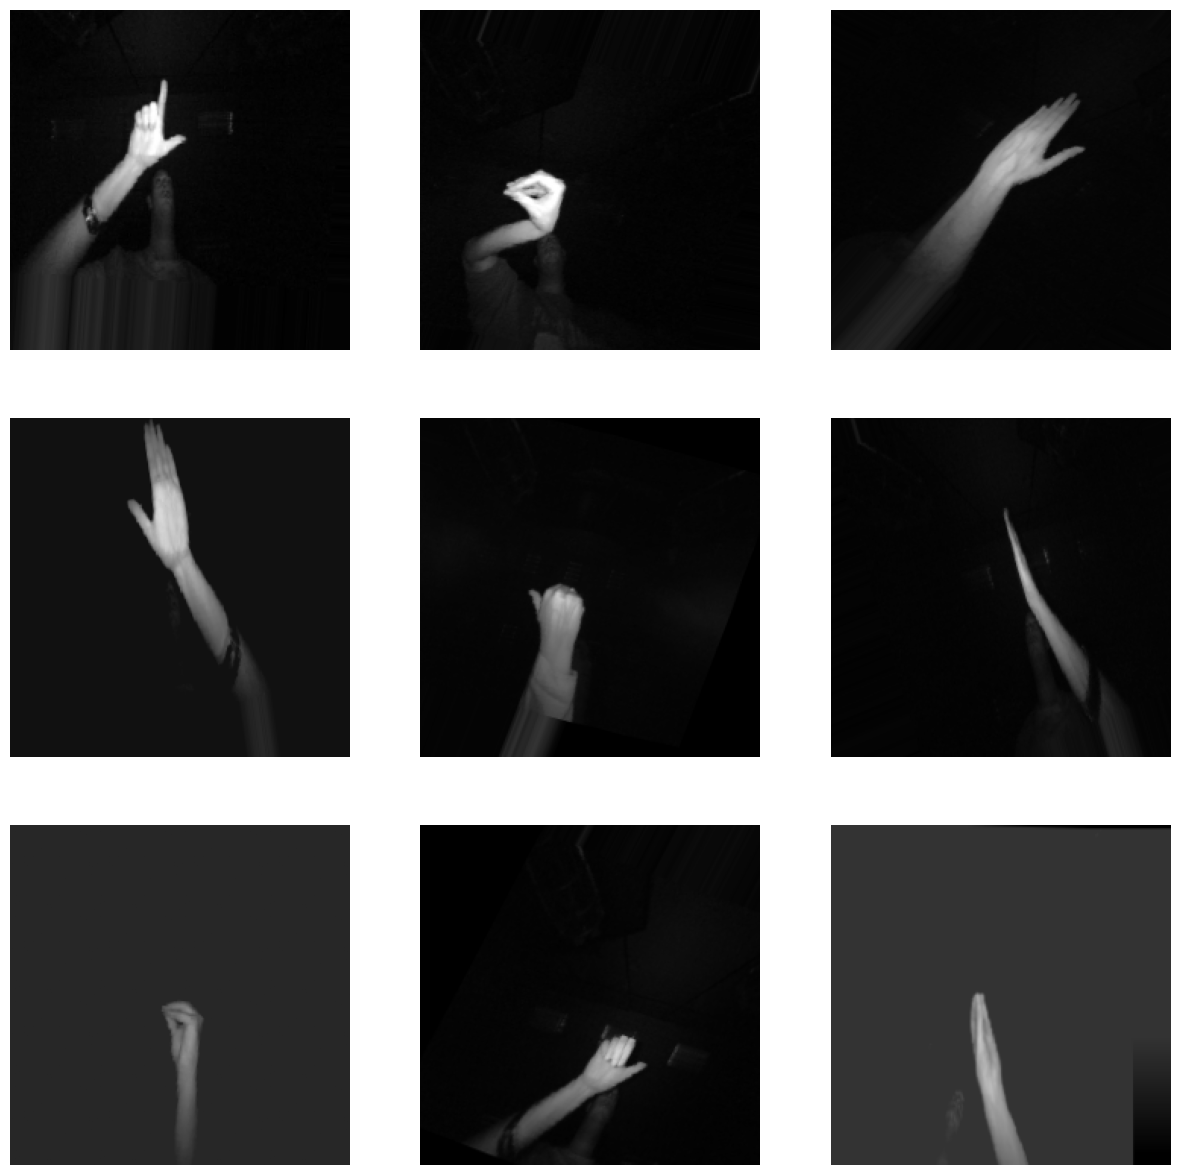

In [77]:
# Initialize a dictionary to store one sample per class
samples_per_class = {}

# Definining the classes names
# class_names = ["up", "pointer_r", "pointer_l", "pointer", "palm_u", "palm_m", "palm", "ele", "down"]

# Iterate over the generator and collect one sample per class
for _ in range(len(validation_generator)):
    X_batch, y_batch = next(validation_generator)
    class_index = np.argmax(y_batch[0])
    if class_index not in samples_per_class:
        samples_per_class[class_index] = X_batch[0]
    if len(samples_per_class) == 9:
        break

# Display the collected samples with class names as captions
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i, (class_index, image) in enumerate(samples_per_class.items()):
    ax = axes[i // 3, i % 3]
    ax.imshow(image)
    ax.axis('off')
    # ax.set_title(class_names[class_index])  # Set the title to the class name
plt.show()

In [101]:
# Loading the pre-trained EfficientNetB0 model for feature extraction
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True

# Adding new layers for fine-tuning
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='swish')(x)
x = Dropout(0.5)(x)
predictions = Dense(9, activation='leaky_relu')(x)

In [102]:
# Creating the final model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

In [103]:
# Compiling the model
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# model compiled using the SGD optimizer, with learning rate of 0.001 and momentum of 0.9 (tried other combinations in previous models)
# used the categorical_crossentropy loss and set accuracy as the metrics.

python(12089) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(12090) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


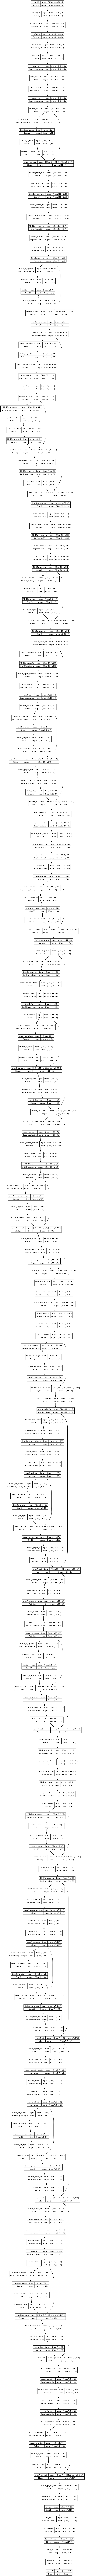

In [104]:
plot_model(model, to_file='Model12_AZ.png', show_shapes=True, show_layer_names=True)

In [105]:
# Creating the model summary
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_28 (Rescaling)    (None, 224, 224, 3)          0         ['input_15[0][0]']            
                                                                                                  
 normalization_14 (Normaliz  (None, 224, 224, 3)          7         ['rescaling_28[0][0]']        
 ation)                                                                                           
                                                                                                  
 rescaling_29 (Rescaling)    (None, 224, 224, 3)          0         ['normalization_14[0][0

In [106]:
# Training the new model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    train_generator,
    steps_per_epoch=(train_generator.samples // train_generator.batch_size) + (train_generator.samples % train_generator.batch_size > 0),
    validation_data=validation_generator,
    validation_steps=(validation_generator.samples // validation_generator.batch_size) + (validation_generator.samples % validation_generator.batch_size > 0),
    epochs=5
)

Epoch 1/5


In [ ]:
# Saving the model
model.save('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_az_12.h5')
model.save('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_az_12.keras')
model.save_weights('//Users//aureozanon//Documents//DAAN570//Project//Models//hg_cnn_weights_az_12.h5')

In [ ]:
# Evaluating the model on the test set
test_loss, test_accuracy = model.evaluate(validation_generator)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
# Setting a seed value for reproducibility of the sample
seed = 74

# Sampling a batch of data from the validation_generator
# x_val_sample contains the image data, y_val_sample contains the corresponding labels
x_val_sample, y_val_sample = validation_generator.next()

# Generating predictions for this batch using the trained model
# predictions will be in the format of probabilities for each class
predictions = model.predict(x_val_sample)

# Converting the prediction probabilities to class indices (highest probability)
# np.argmax is used to find the index of the maximum value across the prediction axis
predicted_classes = np.argmax(predictions, axis=1)

# Convert the true labels from one-hot encoded format to class indices
# This is required to compare with the predicted classes
true_classes = np.argmax(y_val_sample, axis=1)

# Generating the confusion matrix from true and predicted classes
# The confusion matrix gives a summary of how well the model is classifying each class
# Note: It has been used in previous versions of the model to select the subset of 9 out of 12 classes
cm = confusion_matrix(true_classes, predicted_classes)

# Normalizing the confusion matrix so that each row sums to 1
# This helps in comparing classes of different sizes by showing the proportion of correct/incorrect predictions
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Retrieving class labels from the validation_generator
# This will be used to label the axes of the confusion matrix
class_labels = list(validation_generator.class_indices.keys())

# Plotting the normalized confusion matrix using Seaborn
# sns.heatmap creates a heatmap, and 'annot=True' adds annotations to each cell in the matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

